# Assessing the Impact of Question Ambiguity in Question-Answering Systems

**Objective:** Evaluate how effectively LLMs detect and handle ambiguity in questions and analyze the impact on system performance and output uncertainty.

# STEP 1: DATASET GENERATION

We use **SQuAD 2.0: Stanford Question Answering Dataset** (Rajpurkar et al., 2018) as a foundation dataset.

LINKS:
- [Paper](https://arxiv.org/pdf/1806.03822)
- [Project Report](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15785042.pdf)
- [Dataset Explorer](https://rajpurkar.github.io/SQuAD-explorer/)
- [Hugging Face](https://huggingface.co/datasets/rajpurkar/squad_v2)
- [Kaggle](https://www.kaggle.com/datasets/thedevastator/squad2-0-a-challenge-for-question-answering-syst)

SHORT DESCRIPTION OF SQuAD 2.0:
- reading comprehension dataset containing approximately 100k question-answer pairs.  
- each question is linked to a specific context paragraph from a Wikipedia article.
- the answer is a contiguous span of text directly extracted from that context.
- contains nearly 50k (33.4%) unanswerable questions

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [1]:
# import libraries
from datasets import load_dataset
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pandas as pd
import spacy
import json

import ast
import re
import nltk

import openai
from openai import OpenAI
import time

## Dataset Preprocessing

**Procedure:**

- Download the train set of SQuAD 2.0 with a total number of 130.319 questions (train.csv).
- Select only answerable questions.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Download SQuAD 2.0 </b> 
</div>

- The SQuAD 2.0 train.csv for this task is downloaded from [Hugging Face](https://huggingface.co/datasets/rajpurkar/squad_v2).
- Another opion to download from [Kaggle](https://www.kaggle.com/datasets/thedevastator/squad2-0-a-challenge-for-question-answering-syst).

SQuAD 2.0 Dataset Structure:

- 'id': identifier for qa-pair
- 'title': the name of the Wikipedia page
- 'context': Wikipedia page passage
- 'question': original non-ambiguous question
- 'answers': ground truth answer

In [2]:
# Hugging Face
squad = load_dataset("squad_v2")
train_df = squad["train"].to_pandas()

train_df

# Option with Kaggle path
#train_df = pd.read_csv('/kaggle/input/squad2-0-a-challenge-for-question-answering-syst/train.csv') 
#train_df

README.md: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"
...,...,...,...,...,...
130314,5a7e070b70df9f001a875439,Matter,"The term ""matter"" is used throughout physics i...",Physics has broadly agreed on the definition o...,"{'text': [], 'answer_start': []}"
130315,5a7e070b70df9f001a87543a,Matter,"The term ""matter"" is used throughout physics i...",Who coined the term partonic matter?,"{'text': [], 'answer_start': []}"
130316,5a7e070b70df9f001a87543b,Matter,"The term ""matter"" is used throughout physics i...",What is another name for anti-matter?,"{'text': [], 'answer_start': []}"
130317,5a7e070b70df9f001a87543c,Matter,"The term ""matter"" is used throughout physics i...",Matter usually does not need to be used in con...,"{'text': [], 'answer_start': []}"


In [3]:
train_df.columns

Index(['id', 'title', 'context', 'question', 'answers'], dtype='object')

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Select answerable questions </b> 
</div>

Sources for code:

- [pandas.DataFrame.iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html)
- [get() method](https://www.w3schools.com/python/ref_dictionary_get.asp)
- [pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)


In [4]:
# Check the type and content of the answer
print(type(train_df['answers'].iloc[0]))
print(train_df['answers'].iloc[0])

<class 'dict'>
{'text': array(['in the late 1990s'], dtype=object), 'answer_start': array([269], dtype=int32)}


In [5]:
def is_answerable(answer):
    """Extracts only answerable questions from the dataset"""
    try:
        if isinstance(answer, str):
            return False
        return len(answer.get('text', [])) > 0
    except Exception:
        return False

train_df['is_answerable'] = train_df['answers'].apply(is_answerable)
answerable_df = train_df[train_df['is_answerable']].drop(columns=['is_answerable']).copy()

In [6]:
answerable_df

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"
...,...,...,...,...,...
130046,5735d259012e2f140011a09d,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,"{'text': ['Oregon'], 'answer_start': [229]}"
130047,5735d259012e2f140011a09e,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,"{'text': ['Rangoon'], 'answer_start': [414]}"
130048,5735d259012e2f140011a09f,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,"{'text': ['Minsk'], 'answer_start': [476]}"
130049,5735d259012e2f140011a0a0,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,"{'text': ['1975'], 'answer_start': [199]}"


In [9]:
train_df['is_answerable'] = train_df['answers'].apply(is_answerable)

# Keep only answerable rows
answerable_df = train_df[train_df['is_answerable']].drop(columns=['is_answerable']).copy()

print("Original dataset size:", len(train_df))
print("Answerable questions:", len(answerable_df))

Original dataset size: 130319
Answerable questions: 86821


In [10]:
answerable_df.columns

Index(['id', 'title', 'context', 'question', 'answers'], dtype='object')

## Select Ambiguous Words

**Procedure:**
- Keep only nouns in a question
- Choose target words
- Create a curated list of [ambiguous_words], which represent a strong lexical ambiguity and have at least two or more unrelated meanings.
- With a [WordNet](https://wordnet.princeton.edu) (via NLTK) retrieve dictionary senses (synsets) for candidate words.
- Tokenize each question to ensure word-level matching. Ensure that there are no false matches (e.g., define - fine).
- Finalize dataset

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Choose most common nouns</b> 
</div>

Sources for code:

- [spacy.load](https://spacy.io/usage/models)
-  [token.lemma_.lower()](https://spacy.io/api/lemmatizer)
- [token.pos](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/13-POS-Keywords.html)
- [Counter.update() method](https://www.geeksforgeeks.org/python/python-counter-update-method/)
- [Counter.most_common()](https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list)
- [zip(*)](https://stackoverflow.com/questions/29139350/difference-between-ziplist-and-ziplist)

In [11]:
# Load Spacy model
nlp = spacy.load("en_core_web_sm")

In [12]:
# Initalize Counter
noun_counter = Counter()

# Process each question
for question in tqdm(answerable_df['question'], desc="Preprocessing"):
    doc = nlp(question)
    nouns = [token.lemma_.lower() for token in doc if token.pos_ == "NOUN"]
    noun_counter.update(nouns)

# Top 100 nouns
top_common_nouns = noun_counter.most_common(100)
top_common_nouns

Preprocessing: 100%|██████████| 86821/86821 [07:34<00:00, 191.17it/s]


[('year', 3981),
 ('name', 2741),
 ('type', 2424),
 ('people', 1671),
 ('country', 1490),
 ('city', 1460),
 ('group', 1292),
 ('time', 1277),
 ('term', 1144),
 ('state', 1094),
 ('language', 1083),
 ('part', 1072),
 ('system', 1049),
 ('area', 1048),
 ('century', 976),
 ('population', 952),
 ('kind', 859),
 ('government', 791),
 ('school', 787),
 ('percentage', 785),
 ('war', 712),
 ('company', 711),
 ('period', 690),
 ('law', 677),
 ('place', 611),
 ('music', 594),
 ('work', 590),
 ('use', 588),
 ('world', 584),
 ('power', 576),
 ('season', 574),
 ('word', 560),
 ('team', 557),
 ('date', 549),
 ('day', 542),
 ('event', 492),
 ('number', 486),
 ('member', 479),
 ('game', 479),
 ('example', 470),
 ('form', 468),
 ('child', 453),
 ('book', 452),
 ('party', 436),
 ('region', 431),
 ('student', 420),
 ('church', 409),
 ('study', 402),
 ('end', 399),
 ('religion', 384),
 ('rule', 383),
 ('plant', 383),
 ('death', 372),
 ('treaty', 371),
 ('service', 370),
 ('organization', 366),
 ('building

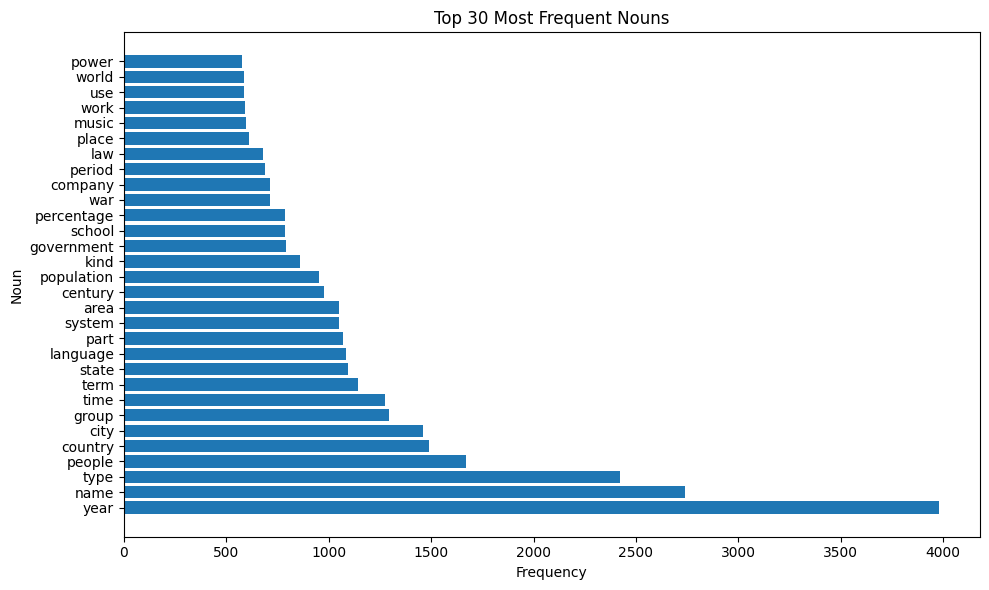

In [13]:
# Extract top 30 most common nouns
top_words = top_common_nouns[:30]

# Split words and its frequencies
words, freq = zip(*top_words)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(words, freq) 
plt.title('Top 30 Most Frequent Nouns')
plt.xlabel('Frequency')
plt.ylabel('Noun')
plt.tight_layout()

# Save chart
plt.savefig("figures/bar_chart_top_nouns_1.png", dpi=300)

plt.show()

In [14]:
# Save 
answerable_df.to_csv("data/answerable_from_squad_1.csv", index=False)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Choose target words and extract WordNet senses</b> 
</div>

Source for code:

- [NLTK](https://www.geeksforgeeks.org/nlp/semantic-analysis-with-nltk/)

In [15]:
# 64 ambiguous words (8x8 sets of words)
# final list
ambiguous_words = [
    "album", "area", "article", "ball", "bank", "bar", "bass", "bill", 
    "board","body","bowl", "cabinet", "capital", "cell", "chair", "change", 
    "club", "company", "court", "date","energy", "fan", "file", "form", 
    "law", "leg", "letter", "line", "march", "match", "movement", "organ", 
    "part", "period", "place", "plant", "port", "post", "power", "process",
    "program", "race", "record", "result", "ring", "rock", "scale", "second", 
    "season", "sentence", "service", "speaker", "spring", "star", "state", "station", 
    "study", "table", "term", "title", "track", "volume", "way","work"
]

In [16]:
# Download WordNet resources
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [17]:
# Store all noun senses
rows = []

# Iterate over ambiguous words
for word in sorted(ambiguous_words):
    # Get nout synsets from WordNet
    noun_synsets = wn.synsets(word, pos=wn.NOUN)
    if noun_synsets:
        for i, synset in enumerate(noun_synsets, 1):
            rows.append({
                "target_word": word,
                "sense": synset.name(),
                "synset_gloss": synset.definition()
            })
    # If no synsets avaliable
    else:
        rows.append({
            "target_word": word,
            "sense": "None",
            "synset_gloss": "No noun senses in WordNet"
        })

# Convert to DataFrame
senses_df = pd.DataFrame(rows)
senses_df

,target_word,sense,synset_gloss
0,album,album.n.01,one or more recordings issued together; origin...
1,album,album.n.02,a book of blank pages with pockets or envelope...
2,area,area.n.01,a particular geographical region of indefinite...
3,area,area.n.02,a subject of study
4,area,area.n.03,a part of an animal that has a special functio...
...,...,...,...
526,work,employment.n.02,the occupation for which you are paid
527,work,study.n.02,applying the mind to learning and understandin...
528,work,work.n.05,(physics) a manifestation of energy; the trans...
529,work,workplace.n.01,a place where work is done


In [19]:
# Synsets of a word 'album'
wn.synsets('album', pos=wn.NOUN)

[Synset('album.n.01'), Synset('album.n.02')]

In [25]:
# Meaning 1
print(wn.synset('album.n.01').definition())

one or more recordings issued together; originally released on 12-inch phonograph records (usually with attractive record covers) and later on cassette audiotape and compact disc


In [26]:
# Meaning 2
print(wn.synset('album.n.02').definition())

a book of blank pages with pockets or envelopes; for organizing photographs or stamp collections etc


In [27]:
# Synsets of a word 'cell'
wn.synsets('cell', pos=wn.NOUN)

[Synset('cell.n.01'),
 Synset('cell.n.02'),
 Synset('cell.n.03'),
 Synset('cell.n.04'),
 Synset('cellular_telephone.n.01'),
 Synset('cell.n.06'),
 Synset('cell.n.07')]

In [33]:
# Print all meanings
synsets = wn.synsets('cell', pos=wn.NOUN)
for i, syn in enumerate(synsets, 1):
    print(f"{i}. {syn.name()} - {syn.definition()}")

1. cell.n.01 - any small compartment
2. cell.n.02 - (biology) the basic structural and functional unit of all organisms; they may exist as independent units of life (as in monads) or may form colonies or tissues as in higher plants and animals
3. cell.n.03 - a device that delivers an electric current as the result of a chemical reaction
4. cell.n.04 - a small unit serving as part of or as the nucleus of a larger political movement
5. cellular_telephone.n.01 - a hand-held mobile radiotelephone for use in an area divided into small sections, each with its own short-range transmitter/receiver
6. cell.n.06 - small room in which a monk or nun lives
7. cell.n.07 - a room where a prisoner is kept


In [18]:
# Save
senses_df.to_csv("data/wordnet_noun_senses.csv", index=False)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>3. Choose questions with ambiguous tokens</b> 
</div>

Sources for code:
- [re.findall()](https://www.geeksforgeeks.org/python/re-findall-in-python/)

In [36]:
# Use previously generated answerable questions from SQuAD 2.0
answerable_df = pd.read_csv('data/answerable_from_squad_1.csv') 
answerable_df.head()

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"


In [38]:
# Extract questions with ambiguous tokens from the final list

def match_ambiguous_token(question):
    """Checks if questions contain ambiguous words from our words list"""
    words = re.findall(r'\b\w+\b', question.lower()) 
    for token in ambiguous_words:
        if token in words:  
            return token
    return None

# New column with ambiguous token
answerable_df["ambiguous_token"] = answerable_df["question"].apply(match_ambiguous_token)
df = answerable_df[answerable_df["ambiguous_token"].notna()].copy()
df.head()

,id,title,context,question,answers,ambiguous_token
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [...",state
6,56bf6b0f3aeaaa14008c9604,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,"{'text': ['Dangerously in Love'], 'answer_star...",album
10,56d43c5f2ccc5a1400d830ab,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the first album Beyoncé released as a...,"{'text': ['Dangerously in Love'], 'answer_star...",album
12,56d43c5f2ccc5a1400d830ad,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,How many Grammy awards did Beyoncé win for her...,"{'text': ['five'], 'answer_start': [590]}",album
14,56d43ce42ccc5a1400d830b5,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the name of Beyoncé's first solo album?,"{'text': ['Dangerously in Love'], 'answer_star...",album


In [39]:
# Load Spacy
nlp = spacy.load("en_core_web_sm")

In [40]:
# Once again filter out and keep only NOUN as pos tag
def get_token_pos(row):
    """Assigns POS tags to tokens in the question"""
    doc = nlp(row["question"])
    for token in doc:
        if token.text.lower() == row["ambiguous_token"].lower():
            return token.pos_
    return "UNKNOWN"

In [41]:
df["pos_tag"] = df.apply(get_token_pos, axis=1)

# Keep only rows where token is used as a NOUN or PROPN
noun_df = df[df["pos_tag"].isin(["NOUN","PROPN"])].copy()

In [43]:
# Data Frame with NOUN or PROPN tags assigned to the words
noun_df.head()

,id,title,context,question,answers,ambiguous_token,pos_tag
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [...",state,NOUN
6,56bf6b0f3aeaaa14008c9604,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN
10,56d43c5f2ccc5a1400d830ab,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the first album Beyoncé released as a...,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN
12,56d43c5f2ccc5a1400d830ad,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,How many Grammy awards did Beyoncé win for her...,"{'text': ['five'], 'answer_start': [590]}",album,NOUN
14,56d43ce42ccc5a1400d830b5,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the name of Beyoncé's first solo album?,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>4. Finalize dataset</b> 
</div>

Sources for code:
- [df.sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html#pandas.DataFrame.sort_values)
- [df.reset_index()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html#pandas.DataFrame.reset_index)

In [46]:
# Check the value of questions per ambiguous token
noun_df["ambiguous_token"].value_counts

<bound method IndexOpsMixin.value_counts of 3         state
6         album
10        album
12        album
14        album
          ...  
130016     area
130027     part
130032     body
130034     part
130046    state
Name: ambiguous_token, Length: 13742, dtype: object>

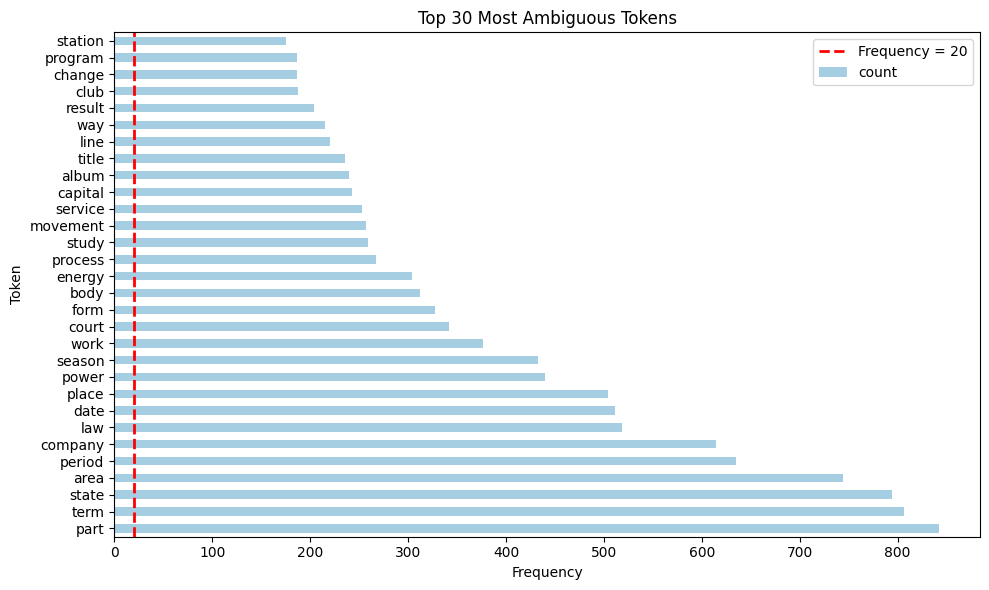

In [48]:
# Get value counts
token_counts = noun_df["ambiguous_token"].value_counts()

# Choose top 30 nouns from our list in the dataset
top_tokens = token_counts.head(30)

# Plot
plt.figure(figsize=(10, 6))
top_tokens.plot(kind='barh', color='#a6cee3')

# Vertical red line at Frequency = 20
# This part was generated with the help of 'gpt-4o' model
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='Frequency = 20')

# Formatting
plt.title('Top 30 Most Ambiguous Tokens')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.legend()
plt.tight_layout()

# Save chart
plt.savefig("top_30_ambiguous_tokens_1.png", dpi=300)
#plt.savefig("figures/top_30_ambiguous_tokens_1.png", dpi=300)

plt.show()


In [50]:
# Limit the number of sentences per word
n = 20  # max samples per ambiguous_token
final_df = noun_df.groupby("ambiguous_token").head(n).reset_index(drop=True)
final_df.head()

,id,title,context,question,answers,ambiguous_token,pos_tag
0,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [...",state,NOUN
1,56bf6b0f3aeaaa14008c9604,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN
2,56d43c5f2ccc5a1400d830ab,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the first album Beyoncé released as a...,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN
3,56d43c5f2ccc5a1400d830ad,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,How many Grammy awards did Beyoncé win for her...,"{'text': ['five'], 'answer_start': [590]}",album,NOUN
4,56d43ce42ccc5a1400d830b5,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the name of Beyoncé's first solo album?,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN


In [53]:
# Sort out sentences by token
final_df_sorted = final_df.sort_values(by=["ambiguous_token", "question"]).reset_index(drop=True)
final_df_sorted.tail()

,id,title,context,question,answers,ambiguous_token,pos_tag
1261,56cf69144df3c31400b0d747,Frédéric_Chopin,"In September 1828 Chopin, while still a studen...",While in Berlin he saw the operatic work of who?,"{'text': ['Gaspare Spontini'], 'answer_start':...",work,NOUN
1262,56cf5433aab44d1400b88fef,Frédéric_Chopin,Chopin's music was used in the 1909 ballet Cho...,Who choreographed a ballet which included Chop...,"{'text': ['Michel Fokine'], 'answer_start': [72]}",work,NOUN
1263,56d3ad7a2ccc5a1400d82e2f,Frédéric_Chopin,Chopin's life was covered in a BBC TV document...,Who did a work for Italian television about Ch...,{'text': ['Angelo Bozzolini and Roberto Prosse...,work,NOUN
1264,56cf5284aab44d1400b88fcc,Frédéric_Chopin,"The British Library notes that ""Chopin's works...",Who played the earlier known recording of Chop...,"{'text': ['Paul Pabst'], 'answer_start': [165]}",work,NOUN
1265,56cbd4c56d243a140015ed7c,Frédéric_Chopin,All of Chopin's compositions include the piano...,Whose music did Frédéric admire the most and t...,"{'text': ['J. S. Bach, Mozart and Schubert'], ...",work,NOUN


In [54]:
final_df_sorted.columns

Index(['id', 'title', 'context', 'question', 'answers', 'ambiguous_token',
       'pos_tag'],
      dtype='object')

In [55]:
# Rename columns
df = final_df_sorted.rename(columns={
    "ambiguous_token": "target_word"
})

df.columns

Index(['id', 'title', 'context', 'question', 'answers', 'target_word',
       'pos_tag'],
      dtype='object')

In [ ]:
# remove unnesessary columns
df = df.drop(columns=['id',
                      'pos_tag'
                     ],errors='ignore')
df

In [56]:
# Export to CSV for annotation
df.to_csv("data/final_dataset_for_annotation_1.csv", index=False)

## Generate Lexically Ambiguous Questions 

**Objective:** rewrite each question to reflect a specific WordNet sense of the ambiguous word, while keeping the word itself in the sentence.

**Procedure:** 

- Create a custom prompt template instructing 'gpt-4o-mini model' to rephrase the question using the specified ambiguous word in a way that it activates one of its specific senses.
- Fill the template with the original question, the ambiguous_token, and the selected sense definition from WordNet.
- Append each generated sample to final_df.

Sources for code:
- [Call OpenAI Function](https://medium.com/@anirudhsyal/breaking-down-the-magic-anatomy-of-a-function-call-to-openai-models-6008a9ce5b18)


In [57]:
# Use dataset generated in the previous step
#df = pd.read_csv('data/final_dataset_for_annotation_1.csv') 
df

,id,title,context,question,answers,target_word,pos_tag
0,56bf8fc1a10cfb1400551177,Beyoncé,Beyoncé's first solo recording was a feature o...,"The album, Dangerously in Love achieved what...","{'text': ['number four'], 'answer_start': [123]}",album,NOUN
1,56be86cf3aeaaa14008c9076,Beyoncé,Following the disbandment of Destiny's Child i...,"After her second solo album, what other entert...","{'text': ['acting'], 'answer_start': [207]}",album,NOUN
2,56be90ee3aeaaa14008c90e5,Beyoncé,Beyoncé's first solo recording was a feature o...,Beyonce's first album by herself was called what?,"{'text': ['Dangerously in Love'], 'answer_star...",album,NOUN
3,56bf8fc1a10cfb1400551175,Beyoncé,Beyoncé's first solo recording was a feature o...,Beyonce's first solo album in the U.S. with wh...,"{'text': ['Jay Z'], 'answer_start': [48]}",album,NOUN
4,56be91b23aeaaa14008c90f0,Beyoncé,"In November 2003, she embarked on the Dangerou...",Destiny's Child's final album was named what?,"{'text': ['Destiny Fulfilled'], 'answer_start'...",album,NOUN
...,...,...,...,...,...,...,...
1261,56cf69144df3c31400b0d747,Frédéric_Chopin,"In September 1828 Chopin, while still a studen...",While in Berlin he saw the operatic work of who?,"{'text': ['Gaspare Spontini'], 'answer_start':...",work,NOUN
1262,56cf5433aab44d1400b88fef,Frédéric_Chopin,Chopin's music was used in the 1909 ballet Cho...,Who choreographed a ballet which included Chop...,"{'text': ['Michel Fokine'], 'answer_start': [72]}",work,NOUN
1263,56d3ad7a2ccc5a1400d82e2f,Frédéric_Chopin,Chopin's life was covered in a BBC TV document...,Who did a work for Italian television about Ch...,{'text': ['Angelo Bozzolini and Roberto Prosse...,work,NOUN
1264,56cf5284aab44d1400b88fcc,Frédéric_Chopin,"The British Library notes that ""Chopin's works...",Who played the earlier known recording of Chop...,"{'text': ['Paul Pabst'], 'answer_start': [165]}",work,NOUN


In [58]:
df.columns

Index(['id', 'title', 'context', 'question', 'answers', 'target_word',
       'pos_tag'],
      dtype='object')

In [60]:
# Add new column for ambiguous question
if "annotated_question" not in df.columns:
    df["annotated_question"] = None  

df.columns

Index(['id', 'title', 'context', 'question', 'answers', 'target_word',
       'pos_tag', 'annotated_question'],
      dtype='object')

In [61]:
# Define lexical prompt template
LEXICAL_PROMPT = """
You are a linguistic question generator specializing in lexical ambiguity.

Your task is to take the following question "{question}" and **rephrase it to reflect a specific meaning** of the word "{word}".

Requirements:
- The rewritten question must keep the word "{word}" in the sentence
- The sentence must reflect one of the meanings of "{word}"
- The sentence must remain fluent and grammatically correct
- The question must remain answerable based on the original context and answer
- Prefer phrasings that could plausibly match **multiple** meanings of the word, not just this one
- Do not define the word or add explanatory context
- Avoid paraphrasing unrelated parts of the sentence

---

Example:

Original question example:
"What is a solar cell?"

Reflect the meaning of "{word}":
"cell"

Rewritten question example:
"What is a cell?"

---

Now apply the same transformation:

Original question:
"{question}"

Reflect the meaning of "{word}":
"{word}"

Result:
"""

In [81]:
import os

# Initialize OpenAI client
client = openai.OpenAI(api_key="sk-...") # private key

def call_gpt(prompt, model="gpt-4o-mini"):
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.7
        )
        return completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error: {e}")
        return None


In [72]:
# This function was written with the help of 'gpt-4o' model
def generate_ambig_questions(
    df, 
    model="gpt-4o-mini", 
    limit=None, 
    save_path="ambig_questions.csv", 
    autosave_every=20
):
    
    # Store output results
    output = []
    df_to_use = df if limit is None else df.iloc[:limit]

    for idx, row in tqdm(df_to_use.iterrows(), total=len(df_to_use), desc="Generating questions"):
        question = row["question"]
        word = row["target_word"]

        prompt = LEXICAL_PROMPT.format(
            word=word,
            question=question
        )

        rewritten = call_gpt(prompt, model=model)
        if not rewritten:
            continue

        output.append({
            "question": question,
            "target_word": word,
            "annotated_question": rewritten,
            "context": row.get("context", ""),
            "answers": row["answers"]
        })

        if (idx + 1) % autosave_every == 0:
            pd.DataFrame(output).to_csv(save_path, index=False)
            print(f"Autosaved after {idx + 1} rows - {save_path}")

        time.sleep(1)

    generated_df = pd.DataFrame(output)
    generated_df.to_csv(save_path, index=False)
    print(f"Save to: {save_path}")
    return generated_df

In [73]:
generated_df = generate_ambig_questions(
    df,
    model="gpt-4o-mini",
    limit=40,
    save_path="model_generated_ambig_questions_1.csv",
    autosave_every=20
)

Generating questions:  37%|███▋      | 14/38 [03:26<07:17, 18.25s/it]

Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-sw7ikPluAW8esfVKmXMm8IKC on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Generating questions:  50%|█████     | 19/38 [04:35<05:13, 16.50s/it]

Autosaved after 20 rows - model_generated_ambig_questions_1.csv


Generating questions:  55%|█████▌    | 21/38 [05:38<07:04, 24.96s/it]

Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-sw7ikPluAW8esfVKmXMm8IKC on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Generating questions:  71%|███████   | 27/38 [06:28<02:57, 16.13s/it]

Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-sw7ikPluAW8esfVKmXMm8IKC on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Generating questions: 100%|██████████| 38/38 [09:09<00:00, 14.45s/it]

Save to: model_generated_ambig_questions_1.csv


In [74]:
df = pd.read_csv('data/model_generated_ambig_questions_1.csv') 
df.head()

,question,target_word,annotated_question,context,answers
0,"The album, Dangerously in Love achieved what...",album,"""What spot did the album achieve on the Billbo...",Beyoncé's first solo recording was a feature o...,"{'text': array(['number four'], dtype=object),..."
1,"After her second solo album, what other entert...",album,"""After her second photo album, what other ente...",Following the disbandment of Destiny's Child i...,"{'text': array(['acting'], dtype=object), 'ans..."
2,Beyonce's first album by herself was called what?,album,"""What was the title of Beyonce's first album?""",Beyoncé's first solo recording was a feature o...,"{'text': array(['Dangerously in Love'], dtype=..."
3,Beyonce's first solo album in the U.S. with wh...,album,"""Beyonce's first solo album in the U.S. featur...",Beyoncé's first solo recording was a feature o...,"{'text': array(['Jay Z'], dtype=object), 'answ..."
4,How many Grammy awards did Beyoncé win for her...,album,"""How many Grammy awards did Beyoncé win for he...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"{'text': array(['five'], dtype=object), 'answe..."


**Interpretation:**
- Based on the LEXICAL PROMPT, the model did not give the output that reflects our goal, therefore manual question annotation was performed to inject ambiguity.